# Data Analysis

Data analysis notebook for the results of the `DINCAE.jl` model training

In [80]:
import xarray
import numpy as np
import matplotlib.pyplot as plt

In [83]:
i = 2 # Index of the trial to analyze
base_folder = f"./results/trial_{i}/"

result = xarray.open_dataset(f"{base_folder}/data-avg.nc")
cleanup = xarray.open_dataset(f"{base_folder}/modis_cleanup.nc")
cleanup_clouds = xarray.open_dataset(f"{base_folder}/modis_cleanup_add_clouds.nc")
# subset = xarray.open_dataset(f"{base_folder}/modis_subset.nc")

In [84]:
# Extracting the relevant data arrays

result_sst = result["sst"].values
# subset_sst = subset["sst"].values
cleanup_sst = cleanup["sst"].values
cleanup_clouds_sst = cleanup_clouds["sst"].values
mask = cleanup_clouds["mask"].values

N = result_sst.shape[0]

result_sst.shape, cleanup_sst.shape, cleanup_clouds_sst.shape, mask.shape

((7149, 106, 149), (7149, 106, 149), (7149, 106, 149), (106, 149))

In [86]:
# Calculate in which days the clouds were applied

added_clouds = []

for i in range(N):
    missing_values = sum(np.isnan(cleanup_sst[i].flatten()))
    missing_values_clouds = sum(np.isnan(cleanup_clouds_sst[i].flatten()))
    if missing_values_clouds > missing_values:
        added_clouds.append(i)
        
print("Added clouds in days:\n", added_clouds)

Added clouds in days:
 [4, 6, 7, 11, 21, 33, 37, 42, 49, 56, 58, 59, 61, 63, 66, 67, 69, 71, 72, 73, 75, 76, 77, 86, 88, 90, 93, 96, 98, 100, 110, 113, 116, 118, 119, 123, 127, 133, 137, 141, 145, 148, 152, 154, 158, 159, 160, 161, 164, 165, 166, 167, 171, 175, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 193, 195, 196, 197, 198, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 217, 220, 224, 225, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 239, 240, 242, 243, 244, 245, 249, 251, 252, 254, 256, 265, 267, 268, 276, 277, 282, 285, 286, 293, 296, 297, 298, 302, 304, 306, 308, 321, 325, 327, 333, 337, 338, 340, 343, 346, 348, 353, 360, 365, 370, 376, 377, 379, 381, 382, 385, 392, 393, 394, 397, 400, 403, 404, 415, 417, 418, 424, 425, 426, 427, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 455, 456, 457, 459, 460, 461, 463, 464, 465, 466, 470, 471, 472, 473, 474, 476, 477, 478

7144
Min: 13.15999984741211, Max: 20.62238311767578


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_36418/4122707940.py:10: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0)


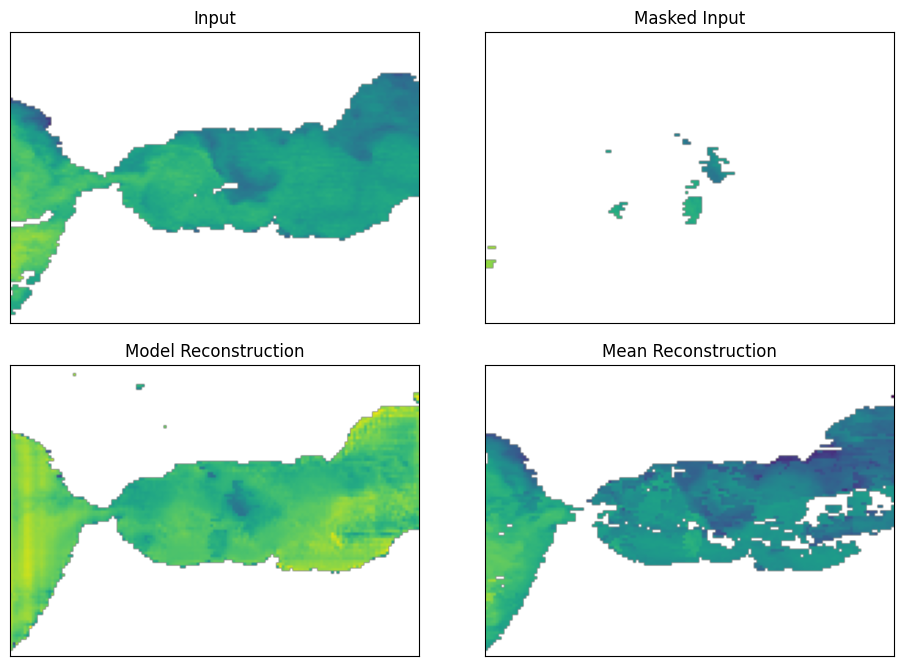

In [101]:
i = added_clouds[-4] # use one day with added clouds for reconstruction
print(i)
time_window = 3 # Specify the time window for reconstruction
n_days = time_window // 2 # Get the number of days before and after the current day

# Reconstruct the image using the model output where clouds were added and the original image otherwise
reconstructed_img = np.where(np.isnan(cleanup_clouds_sst[i]), result_sst[i], cleanup_sst[i])

# Calculate the mean of the surrounding days
mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0)
# Calculate the reconstructed image using the mean of the surrounding days where clouds were added
reconstructed_mean_img = np.where(np.isnan(cleanup_clouds_sst[i]), mean_res, cleanup_sst[i])

# Calculate the min and max values for consistent color scaling
vmin = np.min([np.nanmin(reconstructed_img), np.nanmin(cleanup_clouds_sst[i]), np.nanmin(reconstructed_mean_img)])
vmax = np.max([np.nanmax(reconstructed_img), np.nanmax(cleanup_clouds_sst[i]), np.nanmax(reconstructed_mean_img)])
print(f"Min: {vmin}, Max: {vmax}")

fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

axs[0, 0].imshow(cleanup_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 0].set_title('Input')

axs[0, 1].imshow(cleanup_clouds_sst[i], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 1].set_title('Masked Input')

axs[1, 0].imshow(reconstructed_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 0].set_title('Model Reconstruction')

axs[1, 1].imshow(reconstructed_mean_img, cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 1].set_title('Mean Reconstruction')

plt.tight_layout()
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
# Calculate RMSE between the reconstructed and original images
RMSE_model = np.sqrt(np.nanmean((reconstructed_img - cleanup_sst[i]) ** 2))
RMSE_mean = np.sqrt(np.nanmean((reconstructed_mean_img - cleanup_sst[i]) ** 2))

print(f"RMSE:\n Model: {RMSE_model}\n Mean: {RMSE_mean}")

RMSE: 1.3712409734725952


/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_36418/4046795683.py:1: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0)


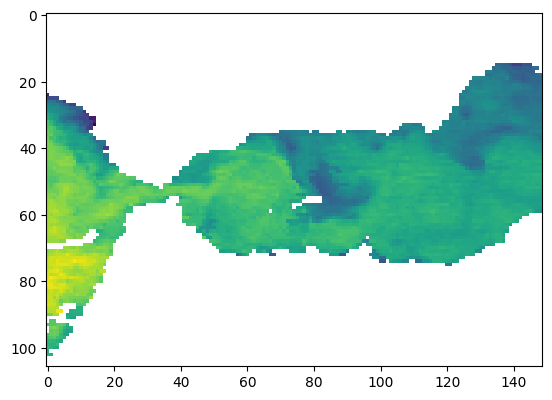

In [ ]:
# Reconstruct the image using a time window around the current day
mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0)
mean_res = np.where(np.isnan(cleanup_clouds_sst[i]), cleanup_sst[i], mean_res)

plt.imshow(mean_res, cmap='viridis', vmin=vmin, vmax=vmax)
plt.show()

In [75]:
RMSE = np.sqrt(np.nanmean((mean_res - cleanup_sst[i]) ** 2))
print(f"RMSE of mean: {RMSE}")

RMSE of mean: 0.08417115360498428


## Calculate mean RMSE

Calculate the mean RMSE of the dataset, using:
- The output of the model
- The mean of the previous and following days

In [76]:
# Calculate where the clouds were applied
mask = np.isnan(cleanup_clouds_sst)

In [77]:
i = 7144
diff = (result_sst[i] - cleanup_sst[i])[mask[i]]

diff.shape

(15619,)

In [ ]:
RMSE_rec = []
RMSE_mean = []

counter = 0
for i in range(n_days, N - n_days):
    mask = np.isnan(cleanup_clouds_sst[i]) # Get where clouds were applied
    if not mask.any(): # If no clouds were applied, skip this iteration
        continue

    diff = (result_sst[i] - cleanup_sst[i])[mask] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue
    rec = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for reconstruction


    mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0) # Calculate the mean of the previous and following days
    diff = (mean_res - cleanup_sst[i])[mask] # Get the difference only where clouds were applied
    if np.isnan(diff).all(): # If all values are NaN, skip this iteration
        continue

    mn = np.sqrt(np.nanmean(diff ** 2)) # Calculate RMSE for mean reconstruction

    if np.isnan(rec) or np.isnan(mn):
        print(f"Skipping {i} due to NaN values in RMSE calculations.")
        continue
        
    counter += 1
    RMSE_rec.append(rec)
    RMSE_mean.append(mn)

print("Number of valid RMSE values:", counter)
print("Mean RMSE Reconstruction:", sum(RMSE_rec) / counter)
print("Mean RMSE Mean:", sum(RMSE_mean) / counter)

/var/folders/q5/4d_bg8zn7h74dy6rjkx80q4w0000gn/T/ipykernel_36418/2576141834.py:16: RuntimeWarning: Mean of empty slice
  mean_res = np.nanmean(cleanup_clouds_sst[i-n_days:i + n_days + 1], axis=0) # Calculate the mean of the previous and following days


Number of valid RMSE values: 976
Mean RMSE Reconstruction: 2.2080803
Mean RMSE Mean: 0.9004845
